In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("asludds")

from lmphoton.simulation import current_simulation as sim
import lmtimesim
from tqdm import tqdm

In [2]:
from lmtimesim.components.Filters.crr import CongoCRR as CRR
crr = CRR()

crr.sim = sim()

um = 1e-6

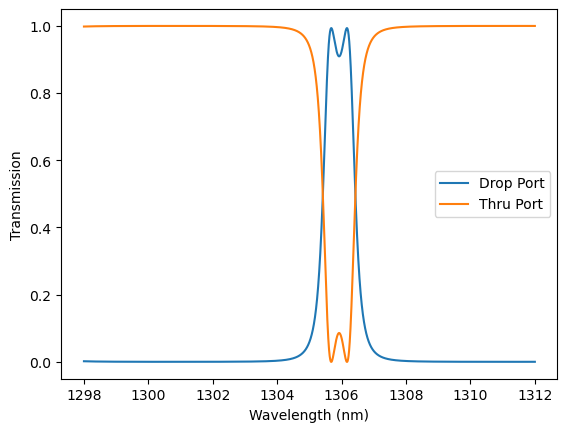

In [3]:
# Do broad wavelength sweeps of the CRR
wavelengths = np.linspace(1.298, 1.312, 10000)*um

crr.bottom_ring_heater_voltage = 0
crr.top_ring_heater_voltage = 0
crr.rc_filter_bool = False
drop_port_storage = []
thru_port_storage = []

for wavelength in wavelengths:
    sim().wavelength = wavelength
    crr._wavelength = wavelength
    drop_port_storage.append(crr.drop_port_transmission())
    thru_port_storage.append(crr.thru_port_transmission())

plt.figure()
plt.plot(wavelengths*1e9,drop_port_storage)
plt.plot(wavelengths*1e9,thru_port_storage)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend(["Drop Port","Thru Port"])
plt.show()

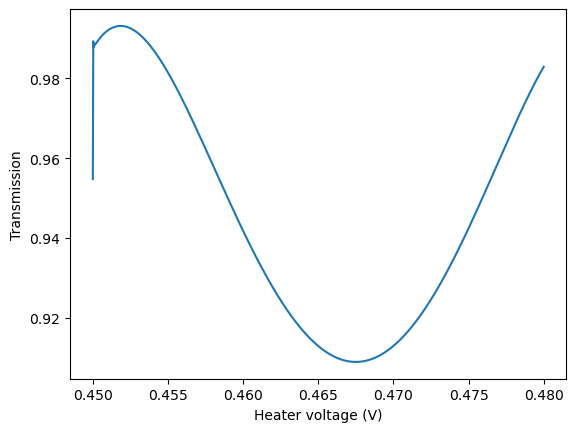

Middle of dip voltage 0.4675075075075075


In [4]:
# Align the CRR to 1310nm center wavelength
heater_voltage_sweep = np.linspace(0.45,0.48,num=1000)
drop_port_storage = []

sim().wavelength = 1310e-9
crr._wavelength = 1310e-9

crr.bottom_ring_heater_voltage = np.min(heater_voltage_sweep)
crr.top_ring_heater_voltage = np.min(heater_voltage_sweep)
crr.drop_port_transmission()

for v in heater_voltage_sweep:
    crr.bottom_ring_heater_voltage = v
    crr.top_ring_heater_voltage = v
    drop_port_storage.append(crr.drop_port_transmission())
    
drop_port_storage = np.array(drop_port_storage)

plt.figure()
plt.plot(heater_voltage_sweep,drop_port_storage)
plt.xlabel("Heater voltage (V)")
plt.ylabel("Transmission")
plt.show()

voltage_to_park_at_center = heater_voltage_sweep[np.argmin(drop_port_storage)]
print(f"Middle of dip voltage {voltage_to_park_at_center}")

crr.bottom_ring_heater_voltage = voltage_to_park_at_center
crr.top_ring_heater_voltage = voltage_to_park_at_center

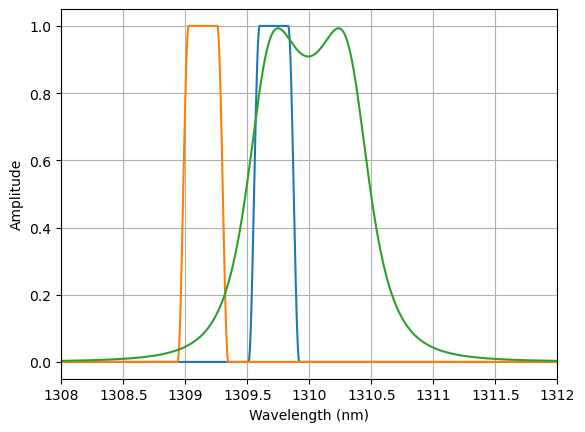

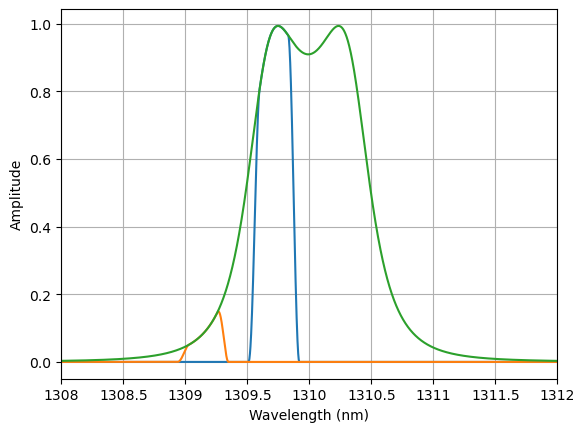

9.864120424647203


In [5]:
# Create a 56G NRZ spectrum
def generate_56G_spectrum(center_wavelength,wavelength_sweep):
    frequency_sweep = c/wavelength_sweep
    center_frequency = c/center_wavelength
    diff_freq = center_frequency - frequency_sweep
    Tb = 1/(56e9)
    tp = np.array([0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])

    tp /= np.max(tp)

    return tp

def raised_cosine(center_wavelength,wavelength_sweep,T=1/(56e9),beta=0.28):
    frequency_sweep = c/wavelength_sweep
    center_frequency = c/center_wavelength
    diff_freq = center_frequency - frequency_sweep
    returnable = []
    for f in diff_freq:
        if np.abs(f) < (1-beta)/(2*T):
            returnable.append(1)
        elif ((1-beta)/(2*T) < np.abs(f)) and (np.abs(f) < (1+beta)/(2*T)):
            returnable.append(0.5 * (1 + np.cos(np.pi *T /beta * (np.abs(f) - (1-beta)/(2*T)))))
        else:
            returnable.append(0)
    return np.array(returnable)

# Applying the raised cosine filter to data:
# rc = raised_cosine(freqs[idx],1/data_rate,beta=0.28)

from scipy.constants import c
baseline_wavelength = 1310e-9
baseline_frequency = c/baseline_wavelength
baseline_frequency_plus_50GHz = baseline_frequency + 50e9
baseline_wavelength_plus_50GHz = c/baseline_frequency_plus_50GHz
baseline_frequency_plus_150GHz = baseline_frequency + 150e9
baseline_wavelength_plus_150GHz = c/baseline_frequency_plus_150GHz

tp_50GHz = raised_cosine(baseline_wavelength_plus_50GHz,wavelengths)
tp_150GHz = raised_cosine(baseline_wavelength_plus_150GHz,wavelengths)

#Create a CRR spectrum to compare
drop_port_storage = []

for wavelength in wavelengths:
    sim().wavelength = wavelength
    crr._wavelength = wavelength
    drop_port_storage.append(crr.drop_port_transmission())

drop_port_storage = np.array(drop_port_storage)

plt.figure()
plt.plot(wavelengths*1e9,tp_50GHz)
plt.plot(wavelengths*1e9,tp_150GHz)
plt.plot(wavelengths*1e9,drop_port_storage)
plt.xlim(1308,1312)
tick_locations = [1308,1308.5,1309,1309.5,1310,1310.5,1311,1311.5,1312]
plt.xticks(tick_locations,[str(i) for i in tick_locations])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot the effect of attenuation
plt.figure()
plt.plot(wavelengths*1e9,tp_50GHz*drop_port_storage)
plt.plot(wavelengths*1e9,tp_150GHz*drop_port_storage)
plt.plot(wavelengths*1e9,drop_port_storage)
plt.xlim(1308,1312)
tick_locations = [1308,1308.5,1309,1309.5,1310,1310.5,1311,1311.5,1312]
plt.xticks(tick_locations,[str(i) for i in tick_locations])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Measure the sum of the spectrum and compare their ratios
ratio = np.sum(tp_50GHz*drop_port_storage)/np.sum(tp_150GHz*drop_port_storage)
print(ratio)

In [6]:
#Create a monte-carlo sim to run
def monte_carlo_sim():
    baseline_wavelength = 1310e-9
    baseline_frequency = c/baseline_wavelength
    baseline_freq_with_variation = np.random.normal(baseline_frequency,scale=(40e9)/4) #Factor of 4 because of 4-sigma
    baseline_freq_aggressor_with_variation = np.random.normal(baseline_frequency+180e9,scale=(40e9)/4)
    baseline_wavelength_with_variation = c/baseline_freq_with_variation
    baseline_wavelength_aggressor_with_variation = c/baseline_freq_aggressor_with_variation

    tp_main = raised_cosine(baseline_wavelength_with_variation,wavelengths)
    tp_aggressor = raised_cosine(baseline_wavelength_aggressor_with_variation,wavelengths)

    # Measure the sum of the spectrum and compare their ratios
    delta_frequency = baseline_freq_aggressor_with_variation - baseline_freq_with_variation
    ratio = np.sum(tp_main*drop_port_storage)/np.sum(tp_aggressor*drop_port_storage)
    return delta_frequency, ratio

monte_carlo_freq_storage = []
monte_carlo_ratio_storage = []
for i in tqdm(range(5001),desc='Monte carlo sim'):
    delta_frequency, ratio = monte_carlo_sim()
    monte_carlo_freq_storage.append(delta_frequency)
    monte_carlo_ratio_storage.append(ratio)

monte_carlo_freq_storage = np.array(monte_carlo_freq_storage)
monte_carlo_ratio_storage = np.array(monte_carlo_ratio_storage)

Monte carlo sim: 100%|██████████| 5001/5001 [01:59<00:00, 41.69it/s]


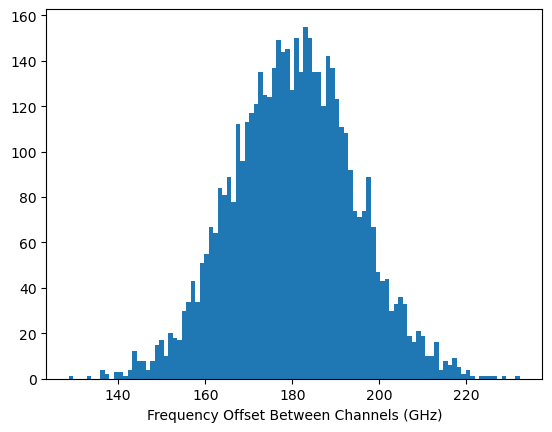

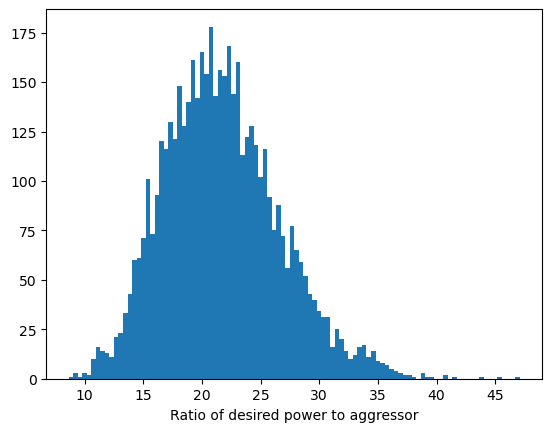

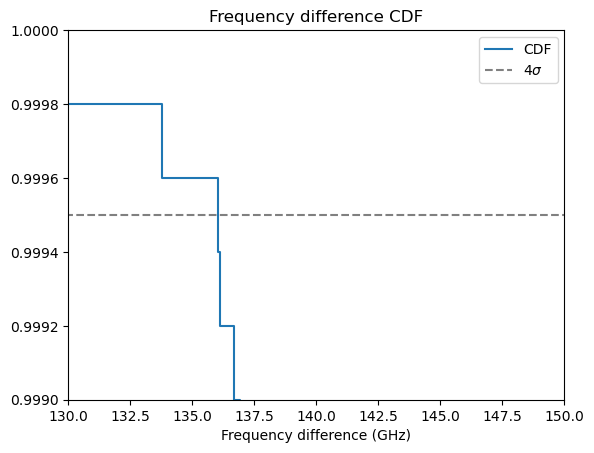

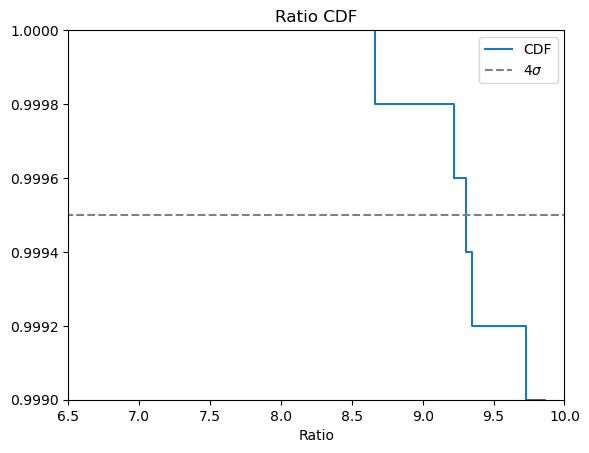

9.325769123619372
136.05614939034373


In [7]:
plt.figure()
plt.hist(monte_carlo_freq_storage*1e-9,bins=100)
plt.xlabel("Frequency Offset Between Channels (GHz)")
plt.show()

plt.figure()
plt.hist(monte_carlo_ratio_storage  ,bins=100)
plt.xlabel("Ratio of desired power to aggressor")
plt.show()

plt.figure()
plt.ecdf(monte_carlo_freq_storage*1e-9  ,complementary=True)
plt.hlines(0.9995,xmin=125,xmax=200,color='grey',linestyle='--')
plt.xlim(130,150)
plt.ylim(0.999,1)
plt.legend(['CDF',r'$4\sigma$'])
plt.title("Frequency difference CDF")
plt.xlabel("Frequency difference (GHz)")
plt.show()

plt.figure()
plt.ecdf(monte_carlo_ratio_storage  ,complementary=True)
plt.hlines(0.9995,xmin=5,xmax=20,color='grey',linestyle='--')
plt.xlim(6.5,10)
plt.ylim(0.999,1)
plt.legend(['CDF',r'$4\sigma$'])
plt.title("Ratio CDF")
plt.xlabel("Ratio")
plt.show()

print(np.percentile(monte_carlo_ratio_storage,100*(1-0.9995)))
print(np.percentile(monte_carlo_freq_storage*1e-9,100*(1-0.9995)))
